In [108]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, KFold, LeaveOneOut
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, auc
from sklearn.decomposition import PCA
import umap
import json
import cupy
from tqdm import tqdm

In [109]:
fdir_raw = Path("../data/raw/")
fdir_processed = Path("../data/interim")
fdir_traintest = Path("../data/processed") / 'sex'
fdir_external = Path("../data/external")
ml_models_fdir = Path("../models")

use_CV = True

model_type = 'catboost'
model_type = 'xgboost'
# model_type = 'knn'

feature_importance_method = 'native'
feature_importance_method = 'SHAP'

n_features = 0

value_to_predict = 'Sex'
# value_to_predict = 'population'
value_to_predict = 'Age'

organ = "HEART"

In [110]:

# fname = next((fdir_external / "HEART" / 'reg').glob("*processed.h5"))
# fname = fname.name

# data = pd.read_hdf(fdir_external / "HEART" / 'reg' / fname, index_col=0)
# data_header = pd.read_csv(fdir_external / "HEART" / 'reg' / 'SraRunTable.txt', sep=',')
# data_header.set_index('Run', inplace=True)


data = pd.read_hdf(fdir_processed / f'{organ}.preprocessed.h5', key="data")
data_header = pd.read_hdf(fdir_processed / f'{organ}.preprocessed.h5', key="header")
# data = pd.read_hdf(fdir_processed / f'{organ}.preprocessed.h5', key="geuvadis")
data


,ENST00000005082.13,ENST00000007699.10,ENST00000011700.10,ENST00000019019.6,ENST00000027335.8,ENST00000043402.8,ENST00000156626.12,ENST00000158526.9,ENST00000160740.7,ENST00000164640.8,...,MSTRG.9912.34,MSTRG.9912.55,MSTRG.9912.90,MSTRG.9924.24,MSTRG.9929.25,MSTRG.9929.3,MSTRG.9947.1,MSTRG.9968.1,MSTRG.9995.3,MSTRG.9997.2
SRR21423854,0.210003,0.317401,0.064221,0.908633,0.181672,0.605823,0.000000,0.000000,0.275802,0.000000,...,1.150995,0.323302,3.747881,0.000000,0.866390,1.310454,0.653897,0.575267,0.000000,0.017333
SRR21423855,0.000000,0.078722,0.435425,0.576384,0.124670,0.000000,0.413680,0.000000,0.000000,1.083077,...,1.895560,0.000000,0.495616,0.801083,0.188541,1.863951,0.163202,0.000000,0.490833,0.035048
SRR21423856,0.000000,1.570842,0.130112,0.987603,1.055833,1.083446,0.000000,0.605504,0.162246,0.147946,...,0.000000,0.000000,4.175363,0.000000,0.103045,0.104439,1.887951,0.000000,0.000000,0.478331
SRR21423857,0.609101,1.542281,0.696431,1.972071,0.735897,0.706419,1.630817,0.000000,0.184158,0.000000,...,0.000000,0.344777,0.000000,0.217798,0.087904,0.145958,0.097166,0.045957,0.231558,0.176368
SRR21423858,0.474505,1.677785,2.987781,0.000000,0.125299,0.000000,0.440663,0.000000,0.007193,1.142542,...,1.985830,1.930535,1.754664,0.000000,0.000000,2.529185,0.827599,1.311947,0.786084,2.368996
SRR21423859,0.000000,1.172751,0.000000,0.173738,0.000000,0.321239,1.912333,0.400809,0.389833,1.007688,...,1.769059,2.120580,0.000000,0.000000,0.530578,0.363909,0.405636,2.228550,0.000000,0.108247
SRR21423860,0.344287,0.370547,2.686339,0.084263,1.050977,1.446001,0.000000,1.613989,0.000000,0.146195,...,0.000000,0.732761,0.000000,0.000000,0.172665,0.192131,0.272126,0.000000,0.586038,0.000000
SRR21423861,0.271710,0.000000,0.000000,0.081132,0.000000,0.000000,2.318324,0.449586,0.255857,0.606563,...,1.086387,0.000000,0.000000,0.000000,0.732944,0.000000,0.136523,0.000215,0.897469,0.000000
SRR21423862,0.478692,0.000000,0.096618,0.447861,0.000000,0.000000,2.252871,0.000000,0.184822,0.000000,...,0.134175,0.000000,2.778027,0.724608,0.470858,0.000000,3.317049,1.906950,0.000000,0.174316
SRR21423863,0.000000,0.537846,0.309450,0.127333,0.079147,0.000000,1.458682,1.067435,0.511147,0.793019,...,0.034321,1.827036,7.101058,0.098270,0.128402,0.330393,0.491464,0.000000,0.000000,0.000428


In [111]:
data = data.iloc[:, np.argwhere(np.sum(data > 0, axis=0) > 19).ravel()]

In [112]:
# y = data_header[value_to_predict]
# X = data.values

sex = 'male'
sex = 'female'

y = data_header.loc[data_header['sex'] == sex][value_to_predict]
X = data.loc[data_header['sex'] == sex].values

X = RobustScaler().fit_transform(X)
# # X = StandardScaler().fit_transform(X)

In [113]:
from scipy.stats import spearmanr

rhos = []
pvalues = []

for i in tqdm(range(X.shape[1])):
    # rho, pvalue = spearmanr(X[:, i], y)
    rho, pvalue = spearmanr(X[:, i], y)
    rhos.append(rho)
    pvalues.append(pvalue)
# rho, pvalue = spearmanr(X, y.values.reshape(1,-1), axis=1)


100%|██████████| 1105/1105 [00:00<00:00, 1525.39it/s]


In [114]:
# np.argwhere(np.array(pvalues) < 0.05).shape
unsignificant_corr_ids = np.argwhere(np.array(pvalues) > 0.05)
# unsignificant_corr_ids

rhos = np.array(rhos)
rhos[unsignificant_corr_ids] = 0
rhos[np.argwhere(X.mean(axis=0) == 0)] = 0




In [115]:
corr_threshold = 0.96
corr_threshold = 0.5

if np.abs(rhos).max() > corr_threshold:
    sorted_corr_border = np.argwhere(np.sort(np.abs(rhos))[::-1] > corr_threshold).max()
    sorted_corr_ids = np.argsort(np.abs(rhos))[::-1][:sorted_corr_border]
    # np.sort(np.abs(rhos))[::-1][:sorted_corr_border], sorted_corr_ids
else:
    sorted_corr_ids = []

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36],
 [Text(0, 0, 'ENST00000372841.8'),
  Text(1, 0, 'ENST00000366529.4'),
  Text(2, 0, 'ENST00000524627.5'),
  Text(3, 0, 'ENST00000679970.1'),
  Text(4, 0, 'ENST00000466186.2'),
  Text(5, 0, 'MSTRG.29296.55'),
  Text(6, 0, 'MSTRG.11225.100'),
  Text(7, 0, 'ENST00000674645.1'),
  Text(8, 0, 'ENST00000361941.7'),
  Text(9, 0, 'ENST00000473696.1'),
  Text(10, 0, 'ENST00000508301.5'),
  Text(11, 0, 'ENST00000462777.1'),
  Text(12, 0, 'ENST00000262963.11'),
  Text(13, 0, 'ENST00000624362.2'),
  Text(14, 0, 'MSTRG.19863.17'),
  Text(15, 0, 'MSTRG.30894.2'),
  Text(16, 0, 'ENST00000590487.1'),
  Text(17, 0, 'ENST00000390323.2'),
  Text(18, 0, 'ENST00000540687.6'),
  Text(19, 0, 'ENST00000591722.5'),
  Text(20, 0, 'ENST00000677299.1'),
  Text(21, 0, 'ENST00000674415.1'),
  Text(22, 0, 'E

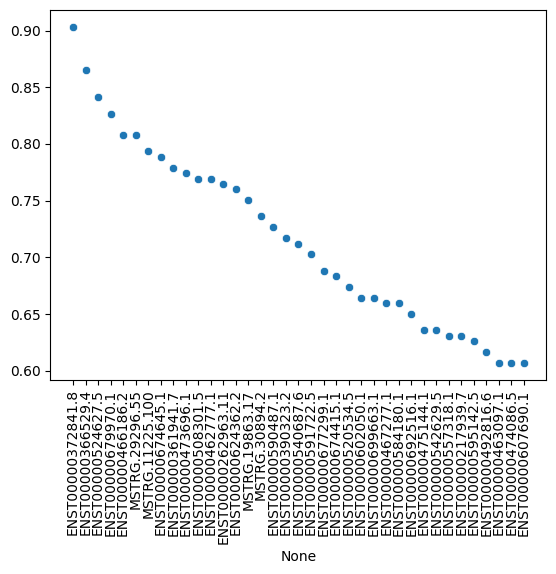

In [116]:
# plt.figure(figsize=(16,6))
sns.scatterplot(
    y=np.abs(rhos[sorted_corr_ids]), 
    x=data.columns[sorted_corr_ids],
    )
plt.xticks(rotation=90)

In [117]:
data.columns[sorted_corr_ids], len(sorted_corr_ids) 

(Index(['ENST00000372841.8', 'ENST00000366529.4', 'ENST00000524627.5',
        'ENST00000679970.1', 'ENST00000466186.2', 'MSTRG.29296.55',
        'MSTRG.11225.100', 'ENST00000674645.1', 'ENST00000361941.7',
        'ENST00000473696.1', 'ENST00000508301.5', 'ENST00000462777.1',
        'ENST00000262963.11', 'ENST00000624362.2', 'MSTRG.19863.17',
        'MSTRG.30894.2', 'ENST00000590487.1', 'ENST00000390323.2',
        'ENST00000540687.6', 'ENST00000591722.5', 'ENST00000677299.1',
        'ENST00000674415.1', 'ENST00000520534.5', 'ENST00000602050.1',
        'ENST00000699663.1', 'ENST00000467277.1', 'ENST00000584180.1',
        'ENST00000692516.1', 'ENST00000475144.1', 'ENST00000542629.5',
        'ENST00000557318.1', 'ENST00000217939.7', 'ENST00000595142.5',
        'ENST00000492816.6', 'ENST00000463097.1', 'ENST00000474086.5',
        'ENST00000607690.1'],
       dtype='object'),
 37)

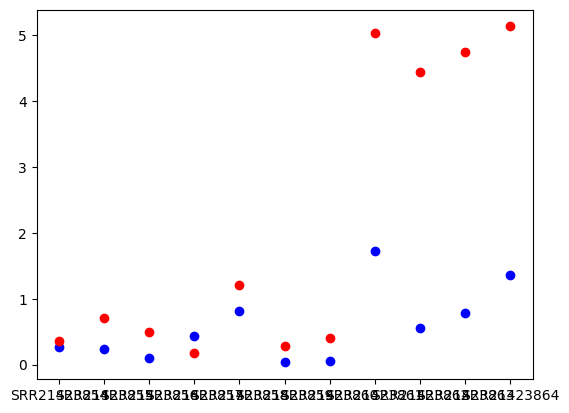

In [118]:
plt.plot(data.loc[data_header['sex'] == sex][data.columns[sorted_corr_ids][0]], 'bo')
plt.plot(data.loc[data_header['sex'] == sex][data.columns[sorted_corr_ids][1]], 'ro')

In [119]:
data.loc[data_header['sex'] == sex][data.columns[sorted_corr_ids][1]]

SRR21423854    0.357158
SRR21423855    0.715284
SRR21423856    0.498932
SRR21423857    0.179542
SRR21423858    1.203160
SRR21423859    0.281182
SRR21423860    0.403331
SRR21423861    5.029414
SRR21423862    4.445617
SRR21423863    4.741581
SRR21423864    5.128942
Name: ENST00000366529.4, dtype: float32

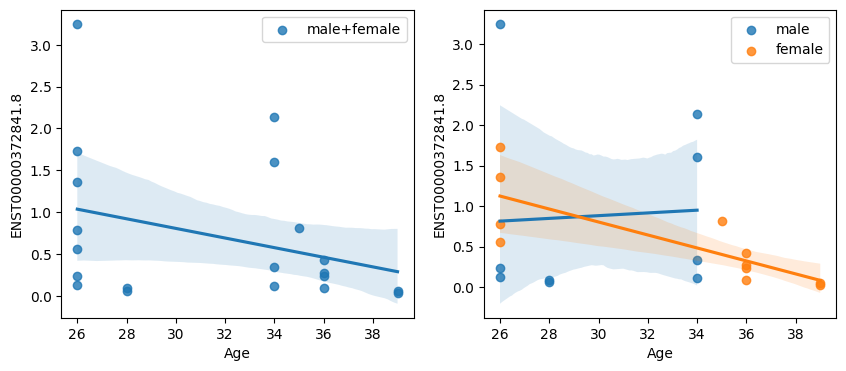

In [120]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
sns.regplot(y=data[data.columns[sorted_corr_ids[0]]], x=data_header['Age'], ax=axs[0], label='male+female')
sns.regplot(y=data[data.columns[sorted_corr_ids[0]]].loc[data_header['sex'] == 'male'], x=data_header['Age'].loc[data_header['sex'] == 'male'], ax=axs[1], 
            label='male')
sns.regplot(y=data[data.columns[sorted_corr_ids[0]]].loc[data_header['sex'] == 'female'], x=data_header['Age'].loc[data_header['sex'] == 'female'], ax=axs[1], 
            label='female')
axs[0].legend()
axs[1].legend()

In [124]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

from sklearn import svm
from xgboost import XGBRegressor


from sklearn.metrics import root_mean_squared_error as RMSE

n_features = 5

# sex = 'male'

X = data.loc[data_header['sex'] == sex, data.columns[sorted_corr_ids[:n_features]]].values
y = data_header['Age'].loc[data_header['sex'] == sex].values

# cv = StratifiedKFold(n_splits=5)
cv = LeaveOneOut()

preds = []
vals  = []

for i, (train, val) in tqdm(enumerate(cv.split(X, y))):
    X_train = X[train]
    y_train = y[train]
    X_test = X[val]
    y_test = y[val]

    # train_scaler = RobustScaler().fit(X_train)
    # test_scaler = RobustScaler().fit(X_test)
    # X_train = train_scaler.transform(X_train)
    # X_test = test_scaler.transform(X_test)

    X_train_ = X_train
    y_train_ = y_train
    X_val = X_test
    y_val = y_test

    model = svm.SVR(kernel='linear')
    # model = LinearRegression()
    # model = XGBRegressor()
    
    # model = GridSearchCV(svm.SVR(kernel='rbf', gamma=0.1),
    #                      param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 20)})    
    
    model.fit(X_train_, y_train_)
    
    pred = model.predict(X_test)
    
    preds.append(pred)
    vals.append(y_val)
    
print(RMSE(preds, vals))

11it [00:00, 2301.92it/s]

1.4362430939194515


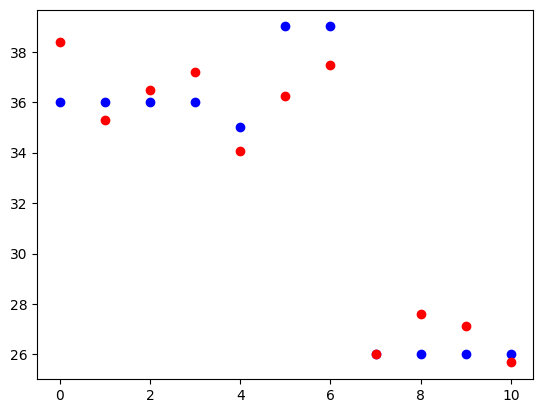

In [122]:
plt.plot(vals, "bo")
plt.plot(preds, "ro")


In [123]:
X

array([[0.27121893, 0.35715786, 0.0575722 , 3.7871027 , 0.62930524],
       [0.23898369, 0.7152837 , 0.01328791, 0.0836478 , 0.06971461],
       [0.09379279, 0.49893194, 0.03026536, 0.08444396, 0.35994494],
       [0.4275708 , 0.17954163, 0.03709681, 0.03447491, 0.17574552],
       [0.8159549 , 1.2031598 , 0.15051027, 0.02741031, 0.04048706],
       [0.03314873, 0.2811818 , 0.0100937 , 4.9248867 , 1.270785  ],
       [0.05657521, 0.40333092, 0.04947884, 2.6944935 , 0.87718433],
       [1.7286615 , 5.0294137 , 0.4003182 , 0.025994  , 0.06368111],
       [0.56080884, 4.445617  , 1.7531364 , 0.02931722, 0.06096321],
       [0.7859866 , 4.741581  , 0.07398887, 0.03914547, 0.07491088],
       [1.3602256 , 5.128942  , 0.16897963, 0.02295715, 0.06416959]],
      dtype=float32)